# Monthly energy consumption

### Import libraries

In [20]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.response
from urllib.parse import urlparse
import datetime
import calendar
import matplotlib.dates as mdates
from urllib.parse import unquote
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
# https://helsinki-openapi.nuuka.cloud/swagger/index.html
# https://www.youtube.com/watch?v=CnqdapOHh8g
# https://dev.hel.fi/paatokset/media/att/0c/0c1a38feb6f9a7b282efd0716c329508eff375cc.pdf

pd.set_option('display.max_colwidth', -1) # näytetään sarakeotsikot kokonaan
pd.set_option('display.max_rows', None) # näytetään kaikki rivit

### Choose industry and date

In [2]:
industries = ['C%20kauppahalli','G%20monitoimitalo',
'F%20lasten%20p%C3%A4iv%C3%A4koti','G%20muu%20kokoontuminen',
'D%20toimisto','H%20ala-aste%20ja%20yl%C3%A4aste',
'H%20ammattiopetus%20ja%20-korkeak.','N%20maa-%20ja%20mets%C3%A4talous',
'N%20muu%20toimiala','K%20varasto',
'G%20kirjasto','C%20ravintola',
'F%20leikkipuisto','G%20museo',
'J%20tukikohta','C%20asuntola',
'C%20muu%20kauppa','A%20asuminen',
'F%20terveyskeskus','G%20liikuntatoimi',
'J%20muu%20tuotanto/teollisuus','H%20muu%20opetusrakennus',
'E%20liikenne','L%20v%C3%A4est%C3%B6nsuoja',
'C%20muu%20halli-%20ja%20ulkomyynti','F%20muu%20sosiaalihuollon%20laitos',
'F%20sairaala','F%20hoitokoti',
'L%20pelastusasema','H%20lukio', 'F%20vanhainkoti']

industry = "F%20sairaala"
industry2 = industry.replace("%20", " ").replace("%C3%A4", "ä").replace("%C3%B6", "ö")
startdate = "1990-01-01"
enddate = "2019-12-31"

### Reading datasets, and parsing dataframes

In [3]:
dfe = pd.read_json("https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Monthly/ListByProperty?Record=PurposeOfUse&SearchString=" + industry + "&ReportingGroup=electricity&StartTime=" + startdate + "&EndTime=" + enddate + "&")
dfh = pd.read_json("https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Monthly/ListByProperty?Record=PurposeOfUse&SearchString=" + industry + "&ReportingGroup=heat&StartTime=" + startdate + "&EndTime=" + enddate + "&")
dfe.drop(columns=['reportingGroup'], inplace=True)
dfe.rename(columns={'value':'electricity'}, inplace=True)
dfh.drop(columns=['reportingGroup'], inplace=True)
dfh.rename(columns={'value':'heat'}, inplace=True)
# df = pd.merge(df,dfh, how='outer')

df = pd.read_json("https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search?SearchString=" + industry + "&SearchFromRecord=purposeofUse")
df.drop(['reportingGroups', 'buildings', 'propertyName', 'buildingType', 'propertyCode'], axis=1, inplace=True)

dfe = pd.merge(dfe, df, on = 'locationName')
dfh = pd.merge(dfh, df, on = 'locationName')
df = pd.merge(dfe,dfh, how='inner')
df['year'] = df['timestamp'].map(lambda x: x.year)
df['month'] = df['timestamp'].map(lambda x: x.month)
df['yearOfIntroduction'] = pd.to_datetime(df['yearOfIntroduction']).map(lambda x: x.year)

# korjataan nolla-arvot, ja nan
df = df.drop(df[df['electricity'] == 0].index)
df.dropna(subset=['electricity', 'heat', 'heatedArea'], inplace=True)

# korjataan pinta-alat
df.loc[df['totalArea'] == 0, 'totalArea'] = df['totalArea'].median()
df.loc[df['heatedArea'] == 0, 'heatedArea'] = df['totalArea'] * 0.7
df.loc[df['volume'] == 0, 'volume'] = df['totalArea'] * 3
df.loc[df['heatedArea'] > df['totalArea'], 'heatedArea'] = df['heatedArea'] / 10

columns = ['timestamp', 'month', 'year', 'locationName', 'purposeOfUse', 'electricity', 'heat', 'unit', 'totalArea', 'heatedArea', 'volume', 'latitude', 'longitude', 'yearOfIntroduction']
df=df[columns]

### Vuosittainen kulutus per neliö

In [15]:
dfvuosi = df.groupby(['locationName', 'year', 'heatedArea', 'volume', 'yearOfIntroduction'])['electricity', 'heat'].sum()
dfvuosi.reset_index(inplace=True)
dfvuosi['lämpö.per.neliö'] = dfvuosi['heat'] / dfvuosi['heatedArea']
dfvuosi['sähkö.per.neliö'] = dfvuosi['electricity'] / dfvuosi['heatedArea']
dfvuosi

,locationName,year,heatedArea,volume,yearOfIntroduction,electricity,heat,lämpö.per.neliö,sähkö.per.neliö
0,"4000 Dh Albert, Entinen Marian sairaala-alue",1990,14877.0,81188.0,1883,2382715.00,4807300.00,323.136385,160.160987
1,"4000 Dh Albert, Entinen Marian sairaala-alue",1991,14877.0,81188.0,1883,2545092.00,4863470.00,326.912012,171.075620
2,"4000 Dh Albert, Entinen Marian sairaala-alue",1992,14877.0,81188.0,1883,2449816.00,4527800.00,304.348995,164.671372
3,"4000 Dh Albert, Entinen Marian sairaala-alue",1993,14877.0,81188.0,1883,2398114.00,4828200.00,324.541238,161.196074
4,"4000 Dh Albert, Entinen Marian sairaala-alue",1994,14877.0,81188.0,1883,2458125.00,5096800.00,342.595953,165.229885
5,"4000 Dh Albert, Entinen Marian sairaala-alue",1995,14877.0,81188.0,1883,2749197.00,5138500.00,345.398938,184.795120
6,"4000 Dh Albert, Entinen Marian sairaala-alue",1996,14877.0,81188.0,1883,2927490.00,5774760.00,388.166969,196.779593
7,"4000 Dh Albert, Entinen Marian sairaala-alue",1997,14877.0,81188.0,1883,1955877.00,5895900.00,396.309740,131.469853
8,"4000 Dh Albert, Entinen Marian sairaala-alue",1998,14877.0,81188.0,1883,3218767.00,5687400.00,382.294818,216.358607
9,"4000 Dh Albert, Entinen Marian sairaala-alue",1999,14877.0,81188.0,1883,3295630.00,5559000.00,373.664045,221.525173


### Vuosittainen energian- ja lämmönkulutus

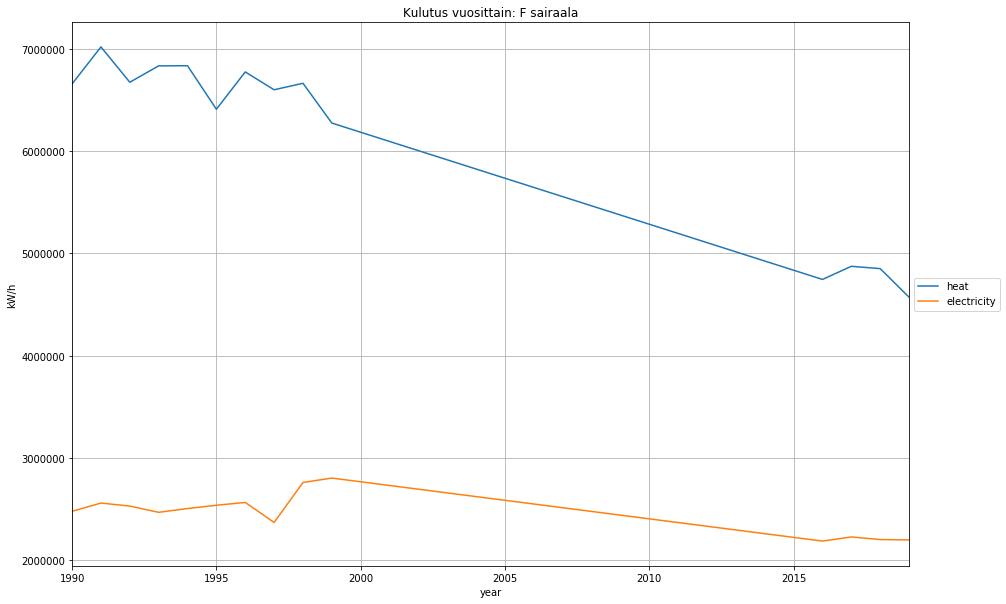

Vuosilta 2000-2015 ei ole dataa saatavilla.


In [5]:
try:
    df2 = pd.DataFrame(df.groupby(['year', 'month'])['electricity', 'heat'].mean())
    df2.reset_index(inplace=True)
    pivot_df = df2.pivot(index='month', columns='year', values=['heat', 'electricity'])
    #print(pivot_df)

except urllib.error.HTTPError: # exception, jos dataa ei löydy 
    print("No data found with the given parameters")

pivot_df = pd.DataFrame(pivot_df.sum().unstack().T)
pivot_df.plot() # luodaan kaavio dfkoko dataframesta
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # siirretään selite kaavion ulkopuolelle 
plt.ylabel('kW/h') # y-akselin otsikko
plt.grid() # laitetaan ruudukko
plt.title('Kulutus vuosittain: ' + industry2) # asetetaan kaavion otsikko
fig = plt.gcf()
fig.set_size_inches(15, 10) # vaihdetaan kaavion kokoa
plt.show() # tulostetaan kaavio
print("Vuosilta 2000-2015 ei ole dataa saatavilla.")

### Kulutus kohteittain

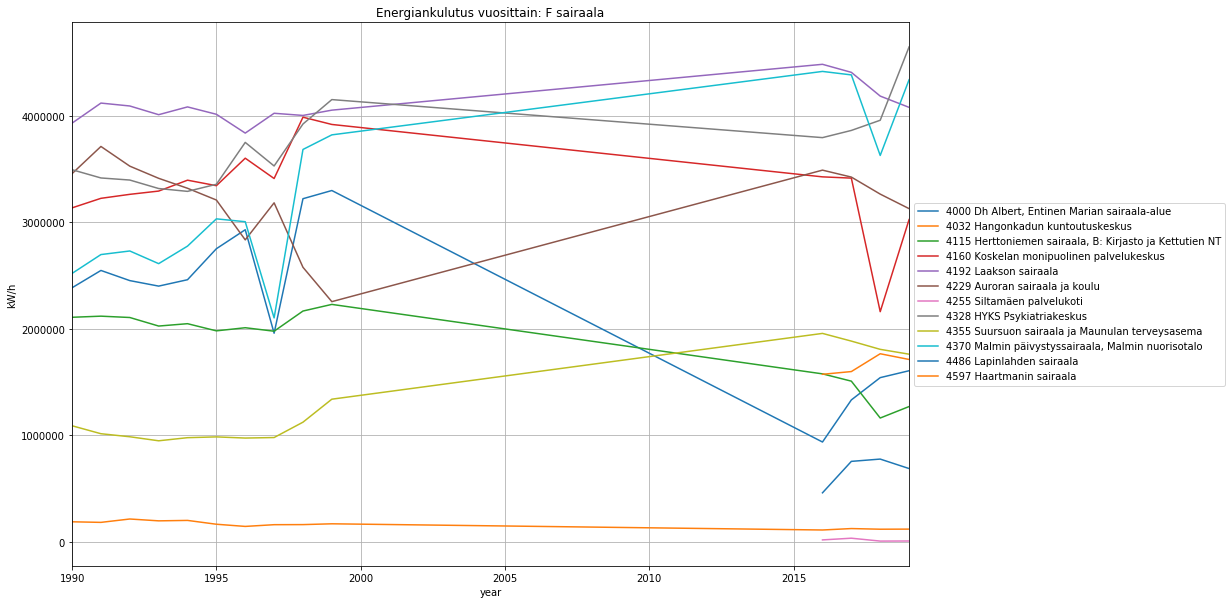

In [6]:
df2 = pd.DataFrame(df.groupby(['locationName', 'year'])['electricity'].sum())
df2.reset_index(inplace=True)
pivot_df2 = df2.pivot(index='year', columns='locationName', values='electricity')

pivot_df2.plot() # luodaan kaavio dfkoko dataframesta
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # siirretään selite kaavion ulkopuolelle 
plt.ylabel('kW/h') # y-akselin otsikko
plt.grid() # laitetaan ruudukko
plt.title('Energiankulutus vuosittain: ' + industry2) # asetetaan kaavion otsikko
fig = plt.gcf()
fig.set_size_inches(15, 10) # vaihdetaan kaavion kokoa
plt.show() # tulostetaan kaavio

### Regressiosuorat lämmitettävän pinta-alan mukaan

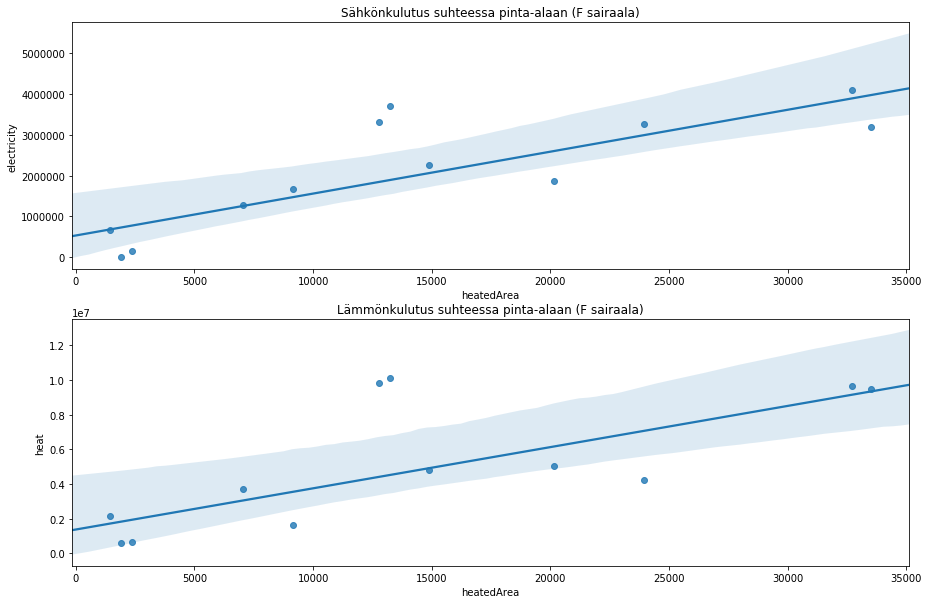

In [16]:
dfgrouped = dfvuosi.groupby(['locationName'])['heatedArea', 'electricity', 'heat', 'volume', 'yearOfIntroduction'].mean()
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.regplot('heatedArea', 'electricity', data=dfgrouped, robust=True)
plt.title('Sähkönkulutus suhteessa pinta-alaan (%s)' % industry2)

plt.subplot(2,1,2)
sns.regplot('heatedArea', 'heat', data=dfgrouped, robust=True)
plt.title('Lämmönkulutus suhteessa pinta-alaan (%s)' % industry2)
plt.show()

### Lineaarinen regressio

In [28]:
reg = linear_model.LinearRegression()
reg.fit(dfgrouped[['heatedArea', 'volume']], dfgrouped['heat'])
reg.predict([[2000, 7500]]) # ARVIOIDAAN SAIRAALARAKENNUKSEN LÄMMÖNKULUTUS LÄMMITETTÄVÄN PINTA-ALAN JA TILAVUUDEN MUKAAN.

array([958650.92950007])

kaikki:  0.703235848001142
ilman käyttöönottovuotta:  0.6574270888736653
[-33.78441662  59.52383646]
579790.9892710159
0.6574270888736653


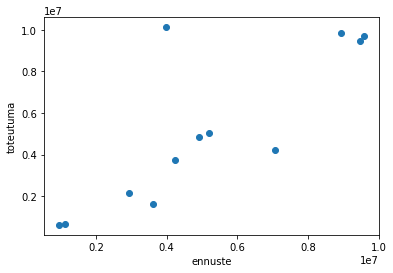

In [25]:
malli1 = LinearRegression()

x = dfgrouped[['heatedArea', 'volume', 'yearOfIntroduction']]
y = dfgrouped['heat']
malli1.fit(x,y)
print('kaikki: ',malli1.score(x,y))

x = dfgrouped[['heatedArea', 'volume']]
y = dfgrouped['heat']
malli1.fit(x,y)
print('ilman käyttöönottovuotta: ',malli1.score(x,y))


print(malli1.coef_)  # kulmakerroin
print(malli1.intercept_) # vakiotermi
print(malli1.score(x,y))

plt.scatter(malli1.predict(x),y)
plt.xlabel('ennuste')
plt.ylabel('toteutuma')
plt.show()

In [17]:
dfgrouped

,heatedArea,electricity,heat,volume,yearOfIntroduction
locationName,,,,,
"4000 Dh Albert, Entinen Marian sairaala-alue",14877.0,2.270493e+06,4.830207e+06,81188.0,1883
4032 Hangonkadun kuntoutuskeskus,2351.3,1.583583e+05,6.757466e+05,10520.0,1924
"4115 Herttoniemen sairaala, B: Kirjasto ja Kettutien NT",20168.0,1.874997e+06,5.044371e+06,88841.0,1971
4160 Koskelan monipuolinen palvelukeskus,12774.9,3.325973e+06,9.840998e+06,147459.0,1910
4192 Laakson sairaala,32699.0,4.091835e+06,9.682352e+06,169631.0,1930
4229 Auroran sairaala ja koulu,33511.0,3.196907e+06,9.483872e+06,168409.0,1914
4255 Siltamäen palvelukoti,1907.0,1.374436e+04,6.113605e+05,7595.0,1889
4328 HYKS Psykiatriakeskus,13227.9,3.703556e+06,1.012768e+07,64816.0,1888
4355 Suursuon sairaala ja Maunulan terveysasema,7045.0,1.270654e+06,3.712961e+06,65652.0,1967
